In [1]:
import numpy as np
import pandas as pd
import os
import time
import torch
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Normalize
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = '../input/sarscov2-ctscan-dataset'
wm_files = os.listdir(data_dir + "/COVID")
print('No. of training examples for COVID:', len(wm_files))
print(wm_files[:5])

No. of training examples for COVID: 1252
['Covid (230).png', 'Covid (1195).png', 'Covid (182).png', 'Covid (817).png', 'Covid (631).png']


In [3]:
# Code to calculate Mean and Std of data
# transform = transforms.Compose([Resize((244,244)), transforms.ToTensor()])
# dataset = ImageFolder(data_dir, transform=transform)
# m = torch.zeros(3)
# s = torch.zeros(3)
# for x,y in dataset:
#     m += x.mean([1,2])
#     s += x.std([1,2])
# mean = m/len(dataset)
# std = s/len(dataset)
# print(mean, std)

In [4]:
stats = ((0.6414, 0.6414, 0.6414), (0.2608, 0.2608, 0.2608))
transform1 = transforms.Compose([Resize((244,244)),transforms.RandomCrop(244, padding=30, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),ToTensor(), transforms.Normalize(*stats,inplace=True)])

In [5]:
random_seed = 42
torch.manual_seed(random_seed)

In [6]:
dataset = ImageFolder(data_dir, transform=transform1)

In [7]:
len(dataset)

2481

In [8]:
val_size = 600
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1881, 600)

In [9]:
batch_size=64

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [11]:
use_gpu = torch.cuda.is_available()
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([64, 1000])

In [12]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [13]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 2)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':val_dl}
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=5)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))
torch.save(model.state_dict(), 'resnet50.pth')

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch [0/4] train loss: 0.0101 acc: 0.6396 valid loss: 0.0049 acc: 0.7333
Epoch [1/4] train loss: 0.0077 acc: 0.8203 valid loss: 0.0040 acc: 0.8050
Epoch [2/4] train loss: 0.0070 acc: 0.8235 valid loss: 0.0035 acc: 0.8083
Epoch [3/4] train loss: 0.0064 acc: 0.8559 valid loss: 0.0032 acc: 0.8567
Epoch [4/4] train loss: 0.0061 acc: 0.8352 valid loss: 0.0031 acc: 0.8417
Best val Acc: 0.856667
Training time:   1.370380 minutes


In [14]:
resnet = models.resnet18(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 2)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':val_dl}
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=5)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))
torch.save(model.state_dict(), 'resnet18.pth')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch [0/4] train loss: 0.0105 acc: 0.6151 valid loss: 0.0057 acc: 0.5317
Epoch [1/4] train loss: 0.0077 acc: 0.7826 valid loss: 0.0046 acc: 0.6783
Epoch [2/4] train loss: 0.0068 acc: 0.8155 valid loss: 0.0034 acc: 0.8300
Epoch [3/4] train loss: 0.0064 acc: 0.8251 valid loss: 0.0033 acc: 0.8333
Epoch [4/4] train loss: 0.0063 acc: 0.8278 valid loss: 0.0034 acc: 0.8133
Best val Acc: 0.833333
Training time:   1.282241 minutes


In [15]:
resnet = models.resnet152(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 2)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':val_dl}
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=5)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))
torch.save(model.state_dict(), 'resnet152.pth')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Epoch [0/4] train loss: 0.0101 acc: 0.6055 valid loss: 0.0044 acc: 0.7717
Epoch [1/4] train loss: 0.0077 acc: 0.7964 valid loss: 0.0036 acc: 0.8350
Epoch [2/4] train loss: 0.0070 acc: 0.8171 valid loss: 0.0033 acc: 0.8383
Epoch [3/4] train loss: 0.0066 acc: 0.8315 valid loss: 0.0032 acc: 0.8450
Epoch [4/4] train loss: 0.0065 acc: 0.8251 valid loss: 0.0030 acc: 0.8550
Best val Acc: 0.855000
Training time:   1.645211 minutes


In [16]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

In [17]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

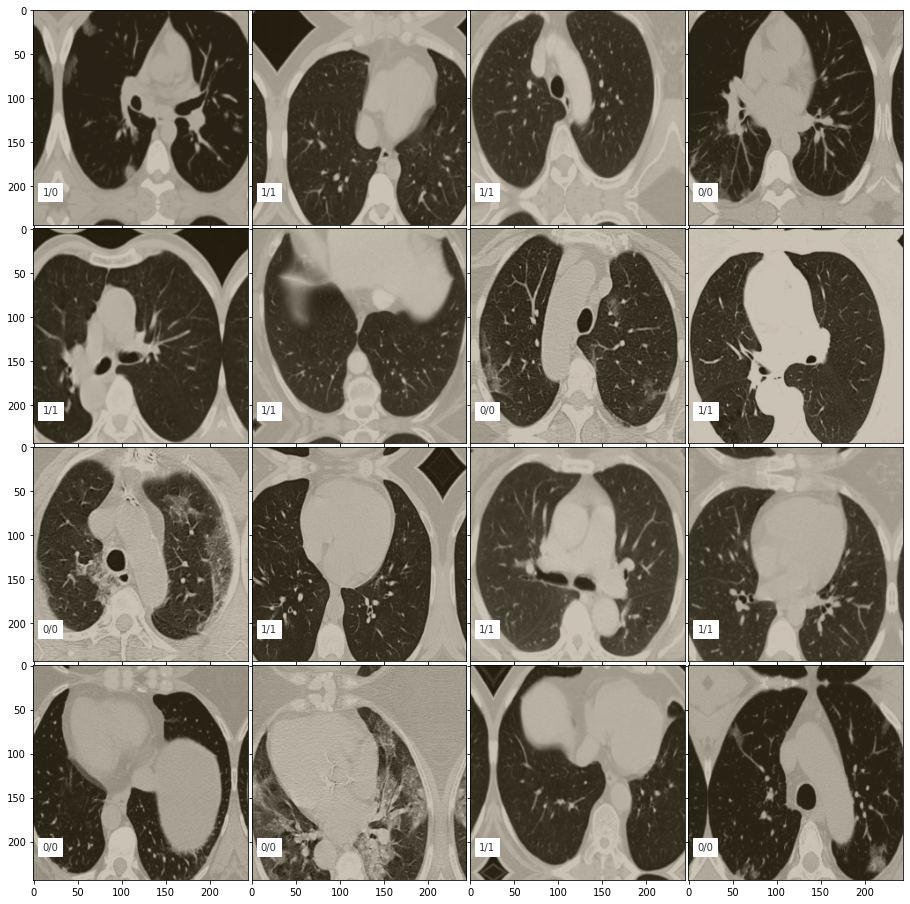

In [18]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 2)
resnet.load_state_dict(torch.load('./resnet50.pth'))
visualize_model(dloaders, resnet)